## Analysis

This notebook contains the code for the analysis of the final dataset. While rigorous econometric analysis is limited to basic stationarity tests (due to the nature of the dataset), some basic tests for market efficiency can reveal a lot of insight as to how the machine learning traders affected the market.

The tests we will conduct will look at a variety of factors, including mean-reversion tendencies, run tests and whether our different types of traders outperformed some simple strategies such as filters and buy-and-hold strategies. We will also perform tests for stationarity and cointegration (between the fundamental price and trading price) although again these should be taken with a grain of salt, as the price series have been generated by our simulations rather than a true random process.

In [447]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import csv
import glob
from tqdm import tqdm
import statsmodels.tsa.stattools as tsa
import collections
import statsmodels.api as sm
from statsmodels.sandbox.stats.runs import runstest_1samp as runtest
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
import statsmodels.formula.api as smf

In [171]:
def unpack_data(filepath): #Returns a dictionary where each item is a df containing one run, one dict per generation
    all_files = glob.glob(filepath + "/*.csv")
    name_list = []
    datadict = {}
    for f in all_files:
        name_list.append(f[89:-4])
    for i,n in enumerate(name_list):
        datadict[n] = pd.read_csv(all_files[i], header=0)
    for k, v in datadict.items():
        v.drop(columns=["Unnamed: 0", "volume", "spread", "10_MA", "50_MA"], inplace=True)
    return datadict

In [172]:
gendict = {}
for i in tqdm(range(51)):
    genname = i
    gendict[genname] = unpack_data(f"/Users/karangarg/Documents/Year 3 Modules/EC331/Code/rae_repo/simulations/gen{i}_sims/data")

100%|██████████| 51/51 [00:19<00:00,  2.59it/s]


In [4]:
def order_dict(datadict): #Takes a dictionary of data and returns an ordered dictionary
    ordered_dict = collections.OrderedDict(sorted(datadict.items()))
    return ordered_dict

In [5]:
gens = np.array([i for i in range(51)])

In [6]:
def compute_mean_squared_diff(datadict): #Returns average mean squared difference, i.e. the square of the average distance between the true price and trading price for any given period in any given simlation
    msd_list = []
    for k, v in datadict.items():
        diff_list = []
        for i in range(len(v)):
            squared_diff = (v.iloc[i]["trading_price"] - v.iloc[i]["true_price"])**2
            diff_list.append(squared_diff)
        msd = sum(diff_list)/len(diff_list)
        msd_list.append(msd) 
    avg_msd = sum(msd_list)/len(msd_list)
    return avg_msd

def gen_msd(gendict): #Computes mean squared difference for all generations and returns a np array with them all
    msd_list = []
    for k, v in gendict.items():
        msd = compute_mean_squared_diff(v)
        msd_list.append(msd)
    msd_array = np.array(msd_list)
    return msd_array

In [7]:
def compute_reversion_rate(datadict, dev=1): #For any given run of the market, how many times does price deviate and how long does it take to return to the true price
    final_avg_return_list = [] #Avg returned run length for individual simulations
    final_avg_no_return_list = [] #Avg run length for not returned runs for individual simulations
    return_run_length_list = [] #Number of deviations per simulation that return for individual simulations
    no_return_run_length_list = [] #Number of deviations per simulation that don't return for individual simulations
    for k, v in datadict.items():
        run_count = 0
        dev_return_list = []
        dev_no_return_list = []
        for i in range(len(v)):
            if abs(v.iloc[i]["trading_price"] - v.iloc[i]["true_price"]) > dev and abs(v.iloc[i-1]["trading_price"] - v.iloc[i-1]["true_price"]) <= dev:
                for t in range(i, len(v)):
                    if abs(v.iloc[t]["trading_price"] - v.iloc[t]["true_price"]) > dev and t == len(v)-1:
                        dev_no_return_list.append(t-i)
                        break
                    elif abs(v.iloc[t]["trading_price"] - v.iloc[t]["true_price"]) <= dev:
                        dev_return_list.append(t-i)
                        break        
        if len(dev_return_list) != 0:
            avg_return_time = sum(dev_return_list)/len(dev_return_list)
            final_avg_return_list.append(avg_return_time)
            return_run_length_list.append(len(dev_return_list))
        if len(dev_no_return_list) != 0:
            avg_no_return_time = sum(dev_no_return_list)/len(dev_no_return_list)
            final_avg_no_return_list.append(avg_no_return_time)
            no_return_run_length_list.append(len(dev_no_return_list))
    final_avg_return = sum(final_avg_return_list)/len(final_avg_return_list) #Length of avg deviation run (that returned)
    final_avg_no_return = sum(final_avg_no_return_list)/len(final_avg_no_return_list) #Length of avg deviation run (that didn't return)
    avg_no_returns = sum(return_run_length_list)/len(datadict) #Avg number of deviations per run that returned
    avg_no_no_returns = sum(no_return_run_length_list)/len(datadict) #Avg number of deviations per run that didn't return
    return final_avg_return, final_avg_no_return, avg_no_returns, avg_no_no_returns

def reversion_stats(gendict):
    returned_run_length_list = []
    unreturned_run_length_list = []
    returned_devs_per_run_list = []
    unreturned_devs_per_run_list = []
    for k, v in gendict.items():
        rrl, url, rdpr, udpr = compute_reversion_rate(v)
        returned_run_length_list.append(rrl)
        unreturned_run_length_list.append(url)
        returned_devs_per_run_list.append(rdpr)
        unreturned_devs_per_run_list.append(udpr)
    returned_run_length_array = np.array(returned_run_length_list)
    unreturned_run_length_array = np.array(unreturned_run_length_list)
    returned_devs_per_run_array = np.array(returned_devs_per_run_list)
    unreturned_devs_per_run_array = np.array(unreturned_devs_per_run_list)
    return returned_run_length_array, unreturned_run_length_array, returned_devs_per_run_array, unreturned_devs_per_run_array

In [8]:
def compute_inefficient_proportion(datadict, dev=1): #Computes the proportion of time that the true and trading prices deviate
    prop_list = []
    for k, v in datadict.items():
        prop_temp = 0
        for i in range(len(v)):
            if abs(v.iloc[i]["trading_price"] - v.iloc[i]["true_price"]) > dev:
                prop_temp +=1
        prop_list.append((prop_temp/len(v)))
    prop = sum(prop_list)/len(prop_list)
    return prop

def inefficient_proportion(gendict):
    ineff_list = []
    for k, v in gendict.items():
        ineff = compute_inefficient_proportion(v)
        ineff_list.append(ineff)
    ineff_array = np.array(ineff_list)
    return ineff_array

In [9]:
def compute_volatility(datadict): #Computes the average volatility for a generation of data
    vol_list = []
    for k, v in datadict.items():
        price_array = v["trading_price"].to_numpy(copy=True)
        vol = np.std(price_array)
        vol_list.append(vol)
    vol_array = np.array(vol_list)
    avg_vol = np.mean(vol_array)
    return avg_vol

def volatility(gendict):
    vol_list = []
    for k, v in gendict.items():
        vol = compute_volatility(v)
        vol_list.append(vol)
    vol_array = np.array(vol_list)
    return vol_array

In [38]:
def compute_stationarity(datadict, p=0.01): #Computes the proportion of a generation that has stationary data
    stat_count = 0
    total_count = 0
    for k, v in datadict.items():
        price_array = v["trading_price"].to_numpy(copy=True)
        try:
            _, pval, _, _, _, _ = tsa.adfuller(price_array, regression="ct")
            if pval < p:
                stat_count += 1
            total_count += 1
        except ValueError:
            pass
    stat_prop = stat_count/total_count
    return stat_prop

def stationary_proportion(gendict, pcrit=0.01):
    stat_list = []
    for k, v in gendict.items():
        stat_prop = compute_stationarity(v, pcrit)
        stat_list.append(stat_prop)
#        print(stat_prop)
    stat_array = np.array(stat_list)
    return stat_array

In [39]:
def compute_coint_proportion(datadict, p=0.01): #Computes the proportion of a generation where both price series are cointegrated
    coint_count = 0
    total_count = 0
    for k, v in datadict.items():
        price_array = v["trading_price"].to_numpy(copy=True)
        true_array = v["true_price"].to_numpy(copy=True)
        try:
            _, pval, _ = tsa.coint(price_array, true_array, trend="nc")
            if pval < p:
                coint_count += 1
            total_count += 1
        except ValueError:
            pass
    coint_prop = coint_count/total_count
    return coint_prop

def cointegrated_proportion(gendict, pcrit=0.01):
    coint_list = []
    for k, v in gendict.items():
        coint_prop = compute_coint_proportion(v, pcrit)
        coint_list.append(coint_prop)
    coint_array = np.array(coint_list)
    return coint_array

In [69]:
def compute_avg_spread(datadict): #Computes the average spread for a generation
    spread_list = []
    for k, v in datadict.items():
        spread = v["spread"].to_numpy(copy=True)
        spread_list.append(np.mean(spread))
    spread_array = np.array(spread_list)
    avg_spread = np.mean(spread_array)
    return avg_spread
    
def avg_spread(gendict):
    spread_list = []
    for k, v in gendict.items():
        avg_spread = compute_avg_spread(v)
        spread_list.append(avg_spread)
    spread_array = np.array(spread_list)
    spread_array = np.negative(spread_array)
    return spread_array

In [65]:
def compute_avg_volume(datadict): #Computes average volume for a generation
    vol_list = []
    for k, v in datadict.items():
        vol = v["volume"].to_numpy(copy=True)
        vol_list.append(np.mean(vol))
    vol_array = np.array(vol_list)
    avg_vol = np.mean(vol_array)
    return avg_vol

def avg_vol(gendict):
    vol_list = []
    for k, v in gendict.items():
        avg_vol = compute_avg_volume(v)
        vol_list.append(avg_vol)
    vol_array = np.array(vol_list)
    return vol_array

In [16]:
msd = gen_msd(gendict)
avg_ret_run, avg_unret_run, no_ret_runs, no_unret_runs = reversion_stats(gendict)
ineff_prop = inefficient_proportion(gendict)
vol = volatility(gendict)
stationary1 = stationary_proportion(gendict)
stationary5 = stationary_proportion(gendict, 0.05)
stationary10 = stationary_proportion(gendict, 0.1)
coint1 = cointegrated_proportion(gendict)
coint5 = cointegrated_proportion(gendict, 0.05)
coint10 = cointegrated_proportion(gendict, 0.1)
volume = avg_vol(gendict)

/Users/karangarg/opt/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1578: RuntimeWarning: divide by zero encountered in double_scalars
  return np.dot(wresid, wresid) / self.df_resid
/Users/karangarg/opt/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:867: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/karangarg/opt/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1578: RuntimeWarning: invalid value encountered in double_scalars
  return np.dot(wresid, wresid) / self.df_resid


In [70]:
spread = avg_spread(gendict)

In [227]:
gendata = pd.DataFrame(data={"volatility": vol,
                             "volume": volume,
                             "stat_prop1": stationary1,
                             "stat_prop5": stationary5,
                             "stat_prop10": stationary10,
                             "coint_prop1": coint1,
                             "coint_prop5": coint5,
                             "coint_prop10": coint10,
                             "spread": spread,
                             "msd": msd,
                             "ineff_prop": ineff_prop,
                             "avg_ret_run": avg_ret_run,
                             "avg_unret_run": avg_unret_run,
                             "no_ret_runs": no_ret_runs,
                             "no_unret_runs": no_unret_runs,
                             "generation": gens}
                       , index=gens)

In [228]:
gendata

,volatility,volume,stat_prop1,stat_prop5,stat_prop10,coint_prop1,coint_prop5,coint_prop10,spread,msd,ineff_prop,avg_ret_run,avg_unret_run,no_ret_runs,no_unret_runs,generation
0,11.300414,22.964998,0.090000,0.160000,0.210000,0.320000,0.390000,0.480000,-1.738130,277.890478,0.524213,4.961648,149.509804,23.280000,0.510000,0
1,10.541052,23.690633,0.060606,0.121212,0.202020,0.380000,0.450000,0.530000,-1.802771,350.780214,0.462623,2.827539,172.372093,22.000000,0.430000,1
2,11.934356,23.742956,0.050000,0.150000,0.290000,0.350000,0.440000,0.470000,-1.861403,486.561322,0.573715,3.913670,214.285714,19.900000,0.560000,2
3,11.958965,25.017446,0.020000,0.070000,0.110000,0.390000,0.500000,0.540000,-1.828283,572.121252,0.487853,3.427061,175.795918,22.100000,0.490000,3
4,14.507198,23.072521,0.060606,0.121212,0.141414,0.320000,0.380000,0.400000,-2.157732,1125.467042,0.565592,4.738985,222.305085,22.210000,0.590000,4
5,11.990094,23.454980,0.020000,0.060000,0.120000,0.290000,0.430000,0.470000,-1.897187,738.260825,0.509428,4.305023,162.423077,24.180000,0.520000,5
6,13.851674,23.420274,0.030303,0.050505,0.070707,0.353535,0.393939,0.454545,-1.905142,817.421288,0.535043,3.711120,213.560000,22.212121,0.505051,6
7,12.335947,25.767300,0.020000,0.080000,0.100000,0.370000,0.430000,0.480000,-1.843119,318.376108,0.495756,4.919995,120.784314,26.890000,0.510000,7
8,12.878311,24.805830,0.030000,0.100000,0.160000,0.340000,0.410000,0.450000,-1.875712,816.928805,0.533675,4.928416,183.166667,21.890000,0.480000,8
9,13.815856,25.060196,0.030303,0.090909,0.111111,0.420000,0.520000,0.550000,-1.882398,802.128704,0.448730,2.589557,153.156863,27.790000,0.510000,9


In [211]:
def reg(Y, X=gendata.index, order=1):
    X = sm.add_constant(X)
    if order == 1:
        model = sm.OLS(Y,X)
    if order == 2:
        model = sm.OLS(Y, X + X**X)
    results = model.fit()
    return results.summary()

-8.18358564279713
761.3740193384618


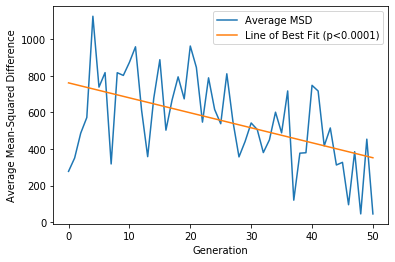

In [362]:
plt.plot(gendata.index, gendata["msd"], label="Average MSD")
m, b = np.polyfit(gendata.index, gendata["msd"], 1)
plt.plot(gendata.index, m*gendata.index + b, label="Line of Best Fit (p<0.0001)")
plt.xlabel("Generation")
plt.ylabel("Average Mean-Squared Difference")
plt.legend()
plt.savefig("msd_fig")
print(m)
print(b)

In [45]:
reg(gendata["msd"])

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    msd   R-squared:                       0.249
Model:                            OLS   Adj. R-squared:                  0.233
Method:                 Least Squares   F-statistic:                     16.22
Date:                Sun, 18 Apr 2021   Prob (F-statistic):           0.000196
Time:                        17:33:00   Log-Likelihood:                -344.91
No. Observations:                  51   AIC:                             693.8
Df Residuals:                      49   BIC:                             697.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        761.3740     58.948     12.916      0.000     642.914     879.834
x1            -8.1836      2.032     -4.028      0.000     -12.267      -4.100
==============================================================================
Omnibus:                        1.151   Durbin-Watson:                   1.527
Prob(Omnibus):                  0.562   Jarque-Bera (JB):                1.184
Skew:                          -0.282   Prob(JB):                        0.553
Kurtosis:                       2.512   Cond. No.                         57.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

0.18286915710089893
23.928742240220362


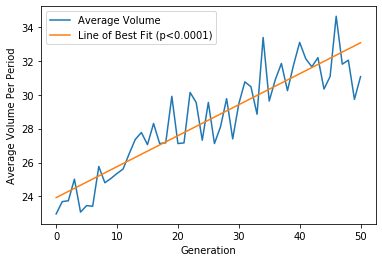

In [364]:
plt.plot(gendata.index, gendata["volume"], label="Average Volume")
m, b = np.polyfit(gendata.index, gendata["volume"], 1)
plt.plot(gendata.index, m*gendata.index + b, label="Line of Best Fit (p<0.0001)")
plt.xlabel("Generation")
plt.ylabel("Average Volume Per Period")
plt.legend()
plt.savefig("volume_fig")
print(m)
print(b)

In [46]:
reg(gendata["volume"])

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 volume   R-squared:                       0.818
Model:                            OLS   Adj. R-squared:                  0.814
Method:                 Least Squares   F-statistic:                     220.0
Date:                Sun, 18 Apr 2021   Prob (F-statistic):           9.51e-20
Time:                        17:34:11   Log-Likelihood:                -84.573
No. Observations:                  51   AIC:                             173.1
Df Residuals:                      49   BIC:                             177.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         23.9287      0.358     66.895      0.000      23.210      24.648
x1             0.1829      0.012     14.832      0.000       0.158       0.208
==============================================================================
Omnibus:                        0.586   Durbin-Watson:                   1.849
Prob(Omnibus):                  0.746   Jarque-Bera (JB):                0.382
Skew:                           0.211   Prob(JB):                        0.826
Kurtosis:                       2.960   Cond. No.                         57.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

-0.0022681111885673776
0.10290600095463372
12.072953592954587


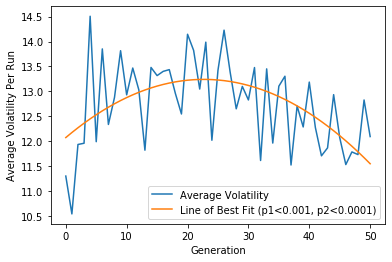

In [367]:
plt.plot(gendata.index, gendata["volatility"], label="Average Volatility")
m1, m2, b = np.polyfit(gendata.index, gendata["volatility"], 2)
plt.plot(gendata.index, m1*(gendata.index**2) + m2*gendata.index + b, label="Line of Best Fit (p1<0.001, p2<0.0001)")
plt.legend()
plt.xlabel("Generation")
plt.ylabel("Average Volatility Per Run")
plt.savefig("volatility_fig")
print(m1)
print(m2)
print(b)

In [47]:
reg(gendata["volatility"])

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             volatility   R-squared:                       0.032
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     1.624
Date:                Sun, 18 Apr 2021   Prob (F-statistic):              0.209
Time:                        17:34:38   Log-Likelihood:                -64.021
No. Observations:                  51   AIC:                             132.0
Df Residuals:                      49   BIC:                             135.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.9991      0.239     54.375      0.000      12.519      13.480
x1            -0.0105      0.008     -1.274      0.209      -0.027       0.006
==============================================================================
Omnibus:                        1.606   Durbin-Watson:                   1.685
Prob(Omnibus):                  0.448   Jarque-Bera (JB):                1.393
Skew:                          -0.398   Prob(JB):                        0.498
Kurtosis:                       2.848   Cond. No.                         57.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [232]:
model3 = smf.ols(formula = f'volatility ~ generation + I(generation**2)', data = gendata).fit()
model3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             volatility   R-squared:                       0.291
Model:                            OLS   Adj. R-squared:                  0.262
Method:                 Least Squares   F-statistic:                     9.859
Date:                Tue, 20 Apr 2021   Prob (F-statistic):           0.000259
Time:                        15:25:43   Log-Likelihood:                -56.076
No. Observations:                  51   AIC:                             118.2
Df Residuals:                      48   BIC:                             123.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             12.0730      0.303     39.888      0.000      11.464      12.682
generation             0.1029      0.028      3.676      0.001       0.047       0.159
I(generation ** 2)    -0.0023      0.001     -4.189      0.000      -0.003      -0.001
==============================================================================
Omnibus:                        0.702   Durbin-Watson:                   2.291
Prob(Omnibus):                  0.704   Jarque-Bera (JB):                0.180
Skew:                           0.071   Prob(JB):                        0.914
Kurtosis:                       3.254   Cond. No.                     3.29e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.29e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

-1.9717537364595646e-05
0.03503839297956944


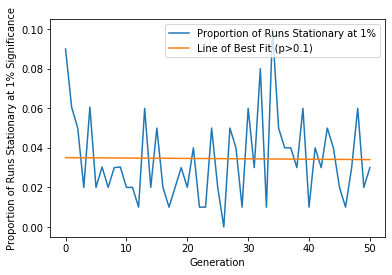

In [369]:
plt.plot(gendata.index, gendata["stat_prop1"], label="Proportion of Runs Stationary at 1%")
m, b = np.polyfit(gendata.index, gendata["stat_prop1"], 1)
plt.plot(gendata.index, m*gendata.index + b, label="Line of Best Fit (p>0.1)")
plt.legend()
plt.xlabel("Generation")
plt.ylabel("Proportion of Runs Stationary at 1% Significance")
plt.savefig("stat1")
print(m)
print(b)

In [48]:
reg(gendata["stat_prop1"])

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             stat_prop1   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.020
Method:                 Least Squares   F-statistic:                  0.008876
Date:                Sun, 18 Apr 2021   Prob (F-statistic):              0.925
Time:                        17:36:14   Log-Likelihood:                 123.31
No. Observations:                  51   AIC:                            -242.6
Df Residuals:                      49   BIC:                            -238.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0350      0.006      5.771      0.000       0.023       0.047
x1         -1.972e-05      0.000     -0.094      0.925      -0.000       0.000
==============================================================================
Omnibus:                        8.681   Durbin-Watson:                   2.095
Prob(Omnibus):                  0.013   Jarque-Bera (JB):                7.966
Skew:                           0.919   Prob(JB):                       0.0186
Kurtosis:                       3.608   Cond. No.                         57.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

-0.0004306503953562775
0.09397877721407133


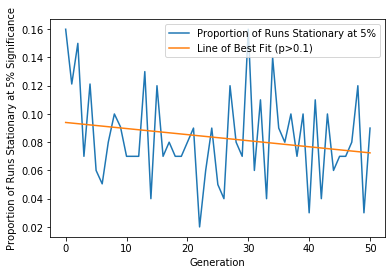

In [371]:
plt.plot(gendata.index, gendata["stat_prop5"], label="Proportion of Runs Stationary at 5%")
m, b = np.polyfit(gendata.index, gendata["stat_prop5"], 1)
plt.plot(gendata.index, m*gendata.index + b, label="Line of Best Fit (p>0.1)")
plt.legend()
plt.xlabel("Generation")
plt.ylabel("Proportion of Runs Stationary at 5% Significance")
plt.savefig("stat5")
print(m)
print(b)

In [49]:
reg(gendata["stat_prop5"])

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             stat_prop5   R-squared:                       0.037
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     1.901
Date:                Sun, 18 Apr 2021   Prob (F-statistic):              0.174
Time:                        17:36:33   Log-Likelihood:                 102.89
No. Observations:                  51   AIC:                            -201.8
Df Residuals:                      49   BIC:                            -197.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0940      0.009     10.372      0.000       0.076       0.112
x1            -0.0004      0.000     -1.379      0.174      -0.001       0.000
==============================================================================
Omnibus:                        1.584   Durbin-Watson:                   2.468
Prob(Omnibus):                  0.453   Jarque-Bera (JB):                1.568
Skew:                           0.379   Prob(JB):                        0.457
Kurtosis:                       2.594   Cond. No.                         57.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

-0.0005927053338818032
0.14197944756768285


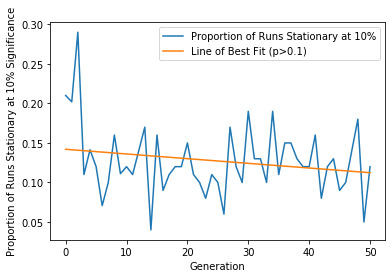

In [372]:
plt.plot(gendata.index, gendata["stat_prop10"], label="Proportion of Runs Stationary at 10%")
m, b = np.polyfit(gendata.index, gendata["stat_prop10"], 1)
plt.plot(gendata.index, m*gendata.index + b, label="Line of Best Fit (p>0.1)")
plt.legend()
plt.xlabel("Generation")
plt.ylabel("Proportion of Runs Stationary at 10% Significance")
plt.savefig("stat10")
print(m)
print(b)

In [50]:
reg(gendata["stat_prop10"])

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            stat_prop10   R-squared:                       0.041
Model:                            OLS   Adj. R-squared:                  0.022
Method:                 Least Squares   F-statistic:                     2.109
Date:                Sun, 18 Apr 2021   Prob (F-statistic):              0.153
Time:                        17:37:54   Log-Likelihood:                 89.243
No. Observations:                  51   AIC:                            -174.5
Df Residuals:                      49   BIC:                            -170.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1420      0.012     11.991      0.000       0.118       0.166
x1            -0.0006      0.000     -1.452      0.153      -0.001       0.000
==============================================================================
Omnibus:                       10.221   Durbin-Watson:                   1.948
Prob(Omnibus):                  0.006   Jarque-Bera (JB):               11.295
Skew:                           0.768   Prob(JB):                      0.00353
Kurtosis:                       4.719   Cond. No.                         57.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

-0.001358115087526853
0.3412770998065115


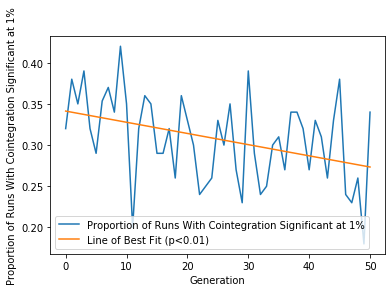

In [373]:
plt.plot(gendata.index, gendata["coint_prop1"], label="Proportion of Runs With Cointegration Significant at 1%")
m, b = np.polyfit(gendata.index, gendata["coint_prop1"], 1)
plt.plot(gendata.index, m*gendata.index + b, label="Line of Best Fit (p<0.01)")
plt.legend()
plt.xlabel("Generation")
plt.ylabel("Proportion of Runs With Cointegration Significant at 1%")
plt.savefig("coint1")
print(m)
print(b)

In [51]:
reg(gendata["coint_prop1"])

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            coint_prop1   R-squared:                       0.148
Model:                            OLS   Adj. R-squared:                  0.131
Method:                 Least Squares   F-statistic:                     8.540
Date:                Sun, 18 Apr 2021   Prob (F-statistic):            0.00524
Time:                        17:39:07   Log-Likelihood:                 82.619
No. Observations:                  51   AIC:                            -161.2
Df Residuals:                      49   BIC:                            -157.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3413      0.013     25.312      0.000       0.314       0.368
x1            -0.0014      0.000     -2.922      0.005      -0.002      -0.000
==============================================================================
Omnibus:                        0.326   Durbin-Watson:                   1.914
Prob(Omnibus):                  0.849   Jarque-Bera (JB):                0.365
Skew:                          -0.177   Prob(JB):                        0.833
Kurtosis:                       2.783   Cond. No.                         57.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

0.00010363362128067941
0.42317267699620637


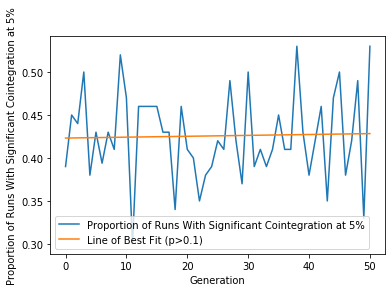

In [374]:
plt.plot(gendata.index, gendata["coint_prop5"], label="Proportion of Runs With Significant Cointegration at 5%")
m, b = np.polyfit(gendata.index, gendata["coint_prop5"], 1)
plt.plot(gendata.index, m*gendata.index + b, label="Line of Best Fit (p>0.1)")
plt.legend()
plt.xlabel("Generation")
plt.ylabel("Proportion of Runs With Significant Cointegration at 5%")
plt.savefig("coint5")
print(m)
print(b)

In [52]:
reg(gendata["coint_prop5"])

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            coint_prop5   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.019
Method:                 Least Squares   F-statistic:                   0.04417
Date:                Sun, 18 Apr 2021   Prob (F-statistic):              0.834
Time:                        17:39:25   Log-Likelihood:                 79.597
No. Observations:                  51   AIC:                            -155.2
Df Residuals:                      49   BIC:                            -151.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4232      0.014     29.579      0.000       0.394       0.452
x1             0.0001      0.000      0.210      0.834      -0.001       0.001
==============================================================================
Omnibus:                        0.003   Durbin-Watson:                   2.415
Prob(Omnibus):                  0.999   Jarque-Bera (JB):                0.140
Skew:                           0.000   Prob(JB):                        0.932
Kurtosis:                       2.743   Cond. No.                         57.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

0.0014120937885643788
0.4630220759632524


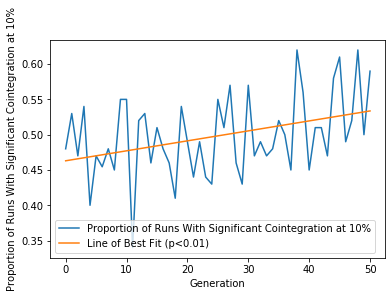

In [375]:
plt.plot(gendata.index, gendata["coint_prop10"], label="Proportion of Runs With Significant Cointegration at 10%")
m, b = np.polyfit(gendata.index, gendata["coint_prop10"], 1)
plt.plot(gendata.index, m*gendata.index + b, label="Line of Best Fit (p<0.01)")
plt.legend()
plt.xlabel("Generation")
plt.ylabel("Proportion of Runs With Significant Cointegration at 10%")
plt.savefig("coint10")
print(m)
print(b)

In [53]:
reg(gendata["coint_prop10"])

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           coint_prop10   R-squared:                       0.134
Model:                            OLS   Adj. R-squared:                  0.116
Method:                 Least Squares   F-statistic:                     7.588
Date:                Sun, 18 Apr 2021   Prob (F-statistic):            0.00822
Time:                        17:41:02   Log-Likelihood:                 77.618
No. Observations:                  51   AIC:                            -151.2
Df Residuals:                      49   BIC:                            -147.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4630      0.015     31.133      0.000       0.433       0.493
x1             0.0014      0.001      2.755      0.008       0.000       0.002
==============================================================================
Omnibus:                        0.547   Durbin-Watson:                   2.390
Prob(Omnibus):                  0.761   Jarque-Bera (JB):                0.648
Skew:                          -0.039   Prob(JB):                        0.723
Kurtosis:                       2.453   Cond. No.                         57.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

-0.0034909748078480545
-1.8778920089221303


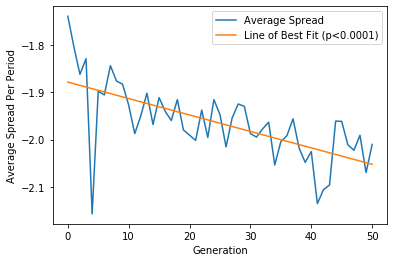

In [376]:
plt.plot(gendata.index, gendata["spread"], label="Average Spread") #Spread is best bid minus best ask
m, b = np.polyfit(gendata.index, gendata["spread"], 1)
plt.plot(gendata.index, m*gendata.index + b, label="Line of Best Fit (p<0.0001)")
plt.legend()
plt.xlabel("Generation")
plt.ylabel("Average Spread Per Period")
plt.savefig("spread_fig")
print(m)
print(b)

In [74]:
reg(gendata["spread"])

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 spread   R-squared:                       0.424
Model:                            OLS   Adj. R-squared:                  0.412
Method:                 Least Squares   F-statistic:                     36.09
Date:                Sun, 18 Apr 2021   Prob (F-statistic):           2.28e-07
Time:                        18:52:22   Log-Likelihood:                 71.221
No. Observations:                  51   AIC:                            -138.4
Df Residuals:                      49   BIC:                            -134.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.8779      0.017   -111.383      0.000      -1.912      -1.844
x1            -0.0035      0.001     -6.007      0.000      -0.005      -0.002
==============================================================================
Omnibus:                       30.888   Durbin-Watson:                   1.664
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               94.521
Skew:                          -1.551   Prob(JB):                     2.99e-21
Kurtosis:                       8.904   Cond. No.                         57.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

-0.0010569773622652976
0.5193844331166051


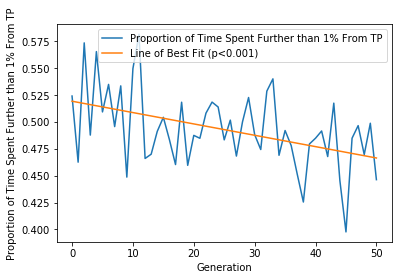

In [377]:
plt.plot(gendata.index, gendata["ineff_prop"], label="Proportion of Time Spent Further than 1% From TP")
m, b = np.polyfit(gendata.index, gendata["ineff_prop"], 1)
plt.plot(gendata.index, m*gendata.index + b, label="Line of Best Fit (p<0.001)")
plt.legend()
plt.xlabel("Generation")
plt.ylabel("Proportion of Time Spent Further than 1% From TP")
plt.savefig("inefficient_prop_fig")
print(m)
print(b)

In [55]:
reg(gendata["ineff_prop"])

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             ineff_prop   R-squared:                       0.191
Model:                            OLS   Adj. R-squared:                  0.175
Method:                 Least Squares   F-statistic:                     11.59
Date:                Sun, 18 Apr 2021   Prob (F-statistic):            0.00133
Time:                        17:41:44   Log-Likelihood:                 103.20
No. Observations:                  51   AIC:                            -202.4
Df Residuals:                      49   BIC:                            -198.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5194      0.009     57.672      0.000       0.501       0.537
x1            -0.0011      0.000     -3.405      0.001      -0.002      -0.000
==============================================================================
Omnibus:                        0.024   Durbin-Watson:                   2.283
Prob(Omnibus):                  0.988   Jarque-Bera (JB):                0.186
Skew:                          -0.028   Prob(JB):                        0.911
Kurtosis:                       2.709   Cond. No.                         57.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

0.007761560184100643
4.105608803785704


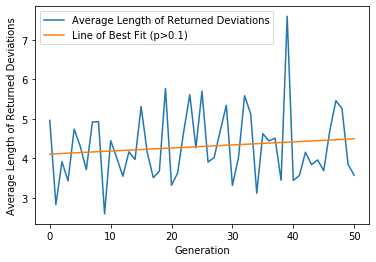

In [378]:
plt.plot(gendata.index, gendata["avg_ret_run"], label="Average Length of Returned Deviations")
m, b = np.polyfit(gendata.index, gendata["avg_ret_run"], 1)
plt.plot(gendata.index, m*gendata.index + b, label="Line of Best Fit (p>0.1)")
plt.legend()
plt.xlabel("Generation")
plt.ylabel("Average Length of Returned Deviations")
plt.savefig("length_returned_devs")
print(m)
print(b)

In [56]:
reg(gendata["avg_ret_run"])

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            avg_ret_run   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                 -0.004
Method:                 Least Squares   F-statistic:                    0.8030
Date:                Sun, 18 Apr 2021   Prob (F-statistic):              0.375
Time:                        17:43:56   Log-Likelihood:                -66.562
No. Observations:                  51   AIC:                             137.1
Df Residuals:                      49   BIC:                             141.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.1056      0.251     16.339      0.000       3.601       4.611
x1             0.0078      0.009      0.896      0.375      -0.010       0.025
==============================================================================
Omnibus:                       10.971   Durbin-Watson:                   2.393
Prob(Omnibus):                  0.004   Jarque-Bera (JB):               11.189
Skew:                           0.911   Prob(JB):                      0.00372
Kurtosis:                       4.394   Cond. No.                         57.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

-2.4509419648258604
193.49070433203136


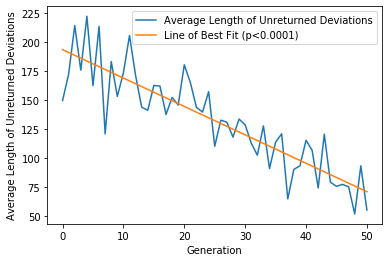

In [379]:
plt.plot(gendata.index, gendata["avg_unret_run"], label="Average Length of Unreturned Deviations")
m, b = np.polyfit(gendata.index, gendata["avg_unret_run"], 1)
plt.plot(gendata.index, m*gendata.index + b, label="Line of Best Fit (p<0.0001)")
plt.legend()
plt.xlabel("Generation")
plt.ylabel("Average Length of Unreturned Deviations")
plt.savefig("length_unreturned_devs")
print(m)
print(b)

In [57]:
reg(gendata["avg_unret_run"])

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          avg_unret_run   R-squared:                       0.758
Model:                            OLS   Adj. R-squared:                  0.753
Method:                 Least Squares   F-statistic:                     153.8
Date:                Sun, 18 Apr 2021   Prob (F-statistic):           9.94e-17
Time:                        17:44:15   Log-Likelihood:                -226.06
No. Observations:                  51   AIC:                             456.1
Df Residuals:                      49   BIC:                             460.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        193.4907      5.733     33.749      0.000     181.969     205.012
x1            -2.4509      0.198    -12.402      0.000      -2.848      -2.054
==============================================================================
Omnibus:                        0.692   Durbin-Watson:                   2.430
Prob(Omnibus):                  0.707   Jarque-Bera (JB):                0.317
Skew:                          -0.187   Prob(JB):                        0.853
Kurtosis:                       3.096   Cond. No.                         57.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

0.429332099273276
20.24222930664106


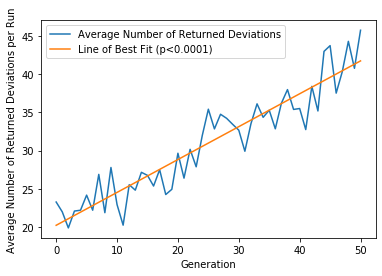

In [380]:
plt.plot(gendata.index, gendata["no_ret_runs"], label="Average Number of Returned Deviations")
m, b = np.polyfit(gendata.index, gendata["no_ret_runs"], 1)
plt.plot(gendata.index, m*gendata.index + b, label="Line of Best Fit (p<0.0001)")
plt.legend()
plt.xlabel("Generation")
plt.ylabel("Average Number of Returned Deviations per Run")
plt.savefig("number_returned_devs")
print(m)
print(b)

In [58]:
reg(gendata["no_ret_runs"])

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            no_ret_runs   R-squared:                       0.875
Model:                            OLS   Adj. R-squared:                  0.873
Method:                 Least Squares   F-statistic:                     344.4
Date:                Sun, 18 Apr 2021   Prob (F-statistic):           8.29e-24
Time:                        17:44:40   Log-Likelihood:                -116.67
No. Observations:                  51   AIC:                             237.3
Df Residuals:                      49   BIC:                             241.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         20.2422      0.671     30.160      0.000      18.893      21.591
x1             0.4293      0.023     18.558      0.000       0.383       0.476
==============================================================================
Omnibus:                        0.859   Durbin-Watson:                   1.838
Prob(Omnibus):                  0.651   Jarque-Bera (JB):                0.817
Skew:                          -0.039   Prob(JB):                        0.665
Kurtosis:                       2.385   Cond. No.                         57.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

0.00032253759312583156
0.4965453936042171


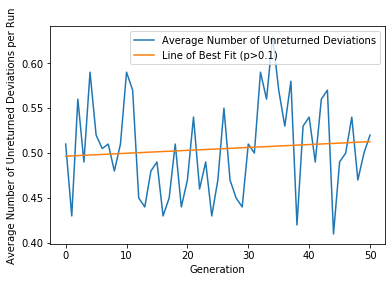

In [381]:
plt.plot(gendata.index, gendata["no_unret_runs"], label="Average Number of Unreturned Deviations")
m, b = np.polyfit(gendata.index, gendata["no_unret_runs"], 1)
plt.plot(gendata.index, m*gendata.index + b, label="Line of Best Fit (p>0.1)")
plt.legend()
plt.xlabel("Generation")
plt.ylabel("Average Number of Unreturned Deviations per Run")
plt.savefig("number_unreturned_devs")
print(m)
print(b)

In [59]:
reg(gendata["no_unret_runs"])

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          no_unret_runs   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                 -0.012
Method:                 Least Squares   F-statistic:                    0.4163
Date:                Sun, 18 Apr 2021   Prob (F-statistic):              0.522
Time:                        17:44:54   Log-Likelihood:                 78.904
No. Observations:                  51   AIC:                            -153.8
Df Residuals:                      49   BIC:                            -149.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4965      0.015     34.240      0.000       0.467       0.526
x1             0.0003      0.000      0.645      0.522      -0.001       0.001
==============================================================================
Omnibus:                        1.401   Durbin-Watson:                   1.656
Prob(Omnibus):                  0.496   Jarque-Bera (JB):                1.240
Skew:                           0.218   Prob(JB):                        0.538
Kurtosis:                       2.373   Cond. No.                         57.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [231]:
model2 = smf.ols(formula = f'no_unret_runs ~ generation + I(generation**2) + I(generation**3)', data = gendata).fit()
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          no_unret_runs   R-squared:                       0.078
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     1.327
Date:                Tue, 20 Apr 2021   Prob (F-statistic):              0.277
Time:                        15:14:44   Log-Likelihood:                 80.762
No. Observations:                  51   AIC:                            -153.5
Df Residuals:                      47   BIC:                            -145.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              0.5373      0.027     19.921      0.000       0.483       0.592
generation            -0.0085      0.005     -1.806      0.077      -0.018       0.001
I(generation ** 2)     0.0004      0.000      1.838      0.072   -3.83e-05       0.001
I(generation ** 3) -5.043e-06    2.9e-06     -1.740      0.088   -1.09e-05    7.86e-07
==============================================================================
Omnibus:                        0.027   Durbin-Watson:                   1.784
Prob(Omnibus):                  0.987   Jarque-Bera (JB):                0.144
Skew:                           0.050   Prob(JB):                        0.931
Kurtosis:                       2.760   Cond. No.                     1.82e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.82e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [77]:
def unpack_states(filepath): #Slightly modified function for unpacking the states data rather than run data
    all_files = glob.glob(filepath + "*.csv")
    name_list = []
    datadict = {}
    for f in all_files:
        name_list.append(f[91:-4])
    for i,n in enumerate(name_list):
        datadict[n] = pd.read_csv(all_files[i], header=0)
#    for k, v in datadict.items():
#        v.drop(columns=["Unnamed: 0", "volume", "spread", "10_MA", "50_MA"], inplace=True)
    return datadict

In [241]:
fsdict = {}
for i in tqdm(range(51)):
    fsname = i
    fsdict[fsname] = unpack_states(f"/Users/karangarg/Documents/Year 3 Modules/EC331/Code/rae_repo/simulations/gen{i}_sims/states/final")    

100%|██████████| 51/51 [00:19<00:00,  2.64it/s]


In [242]:
isdict = {}
for i in tqdm(range(51)):
    isname = i
    isdict[isname] = unpack_states(f"/Users/karangarg/Documents/Year 3 Modules/EC331/Code/rae_repo/simulations/gen{i}_sims/states/state0")    

100%|██████████| 51/51 [00:13<00:00,  3.85it/s]


In [384]:
def dom_flavour(fsdatadict): #Returns a dictionary of the count of the top flavour for each run within a generation
    toparb = 0
    topchart = 0
    topval = 0
    topnoise = 0
    toplstm = 0
    for k, v in fsdatadict.items():
        arbcount = 0
        chartcount = 0
        valcount = 0
        noisecount = 0
        lstmcount = 0
        for i in range(len(v)):
            if v.iloc[i]["flavour"] == "arb":
                arbcount += 1
            elif v.iloc[i]["flavour"] == "chart":
                chartcount += 1
            elif v.iloc[i]["flavour"] == "val":
                valcount += 1
            elif v.iloc[i]["flavour"] == "noise":
                noisecount += 1
            elif v.iloc[i]["flavour"] == "lstm":
                lstmcount += 1
        countdict = {arbcount: "arb", chartcount: "chart", valcount: "val", noisecount: "noise", lstmcount: "lstm"}
        topflavour = countdict.get(max(countdict))
        if topflavour == "arb":
            toparb += 1
        elif topflavour == "chart":
            topchart += 1
        elif topflavour == "val":
            topval += 1
        elif topflavour == "noise":
            topnoise += 1
        elif topflavour == "lstm":
            toplstm += 1
    topflavourdict = {"arb": toparb, "chart": topchart, "val":topval, "noise": topnoise, "lstm": toplstm}
    return topflavourdict

def dom_flavour_all(fsdict):
    listoftopdicts = []
    for k, v in fsdict.items():
        topflavour = dom_flavour(v)
        listoftopdicts.append(topflavour)
    return listoftopdicts

def top_flavour_arrays(toplist):
    arbtop = []
    charttop = []
    valtop = []
    noisetop = []
    lstmtop = []
    for i in toplist:
        arbtop.append(i["arb"])
        charttop.append(i["chart"])
        valtop.append(i["val"])
        noisetop.append(i["noise"])
        lstmtop.append(i["lstm"])
    arbarray = np.array(arbtop)
    chartarray = np.array(charttop)
    valarray = np.array(valtop)
    noisearray = np.array(noisetop)
    lstmarray = np.array(lstmtop)
    return arbarray, chartarray, valarray, noisearray, lstmarray

In [385]:
topflavourslist = dom_flavour_all(fsdict)

In [386]:
arbtop, charttop, valtop, noisetop, lstmtop = top_flavour_arrays(topflavourslist)

In [387]:
proportion_data = pd.DataFrame(data={"Arbitrageurs": arbtop,
                               "Chartists": charttop,
                               "Value Traders": valtop,
                               "Noise Traders": noisetop,
                               "Algorithmic Traders": lstmtop}, index=gens)

In [388]:
proportion_data

,Arbitrageurs,Chartists,Value Traders,Noise Traders,Algorithmic Traders
0,61,19,19,1,0
1,64,21,14,1,0
2,52,24,23,1,0
3,63,22,13,2,0
4,50,32,18,0,0
5,59,26,15,0,0
6,59,25,14,1,0
7,64,14,21,1,0
8,56,23,19,2,0
9,66,19,13,2,0


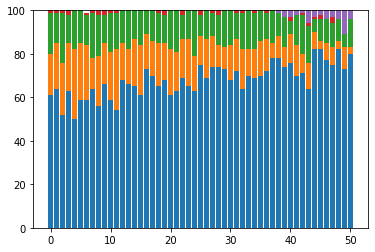

In [178]:
#p1 = plt.bar(statesdata.index, arbtop)
#p2 = plt.bar(statesdata.index, charttop, bottom=arbtop)
#p3 = plt.bar(statesdata.index, valtop, bottom=arbtop+charttop)
#p4 = plt.bar(statesdata.index, noisetop, bottom=arbtop+charttop+valtop)
#p5 = plt.bar(statesdata.index, lstmtop, bottom=arbtop+charttop+valtop+noisetop)

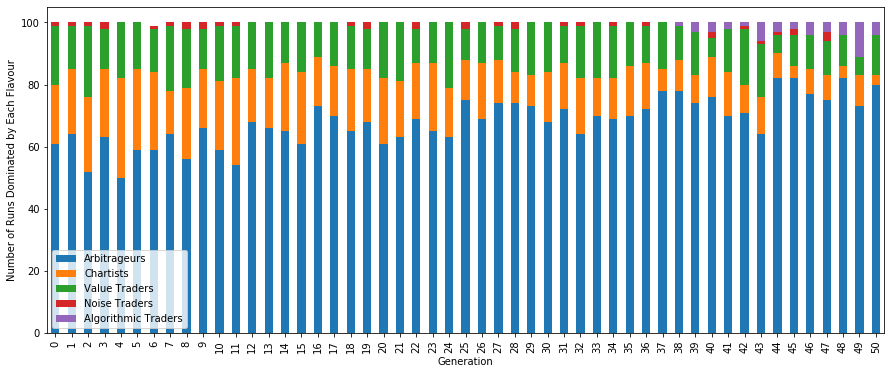

In [389]:
ax = proportion_data.plot(kind="bar", stacked=True, figsize=(15, 6))
plt.xlabel("Generation")
plt.ylabel("Number of Runs Dominated by Each Flavour")
plt.savefig("top_flavour_fig")

In [392]:
def compute_top_earner(fsdatadict): #Records flavour of top earner from each market run
    arbtop = 0
    charttop = 0
    valtop = 0
    noisetop = 0
    lstmtop = 0
    for k, v in fsdatadict.items():
        sortedv = v.sort_values(by=["acc"], ascending=False)
        topflavour = sortedv.iloc[0]["flavour"]
        if topflavour == "arb":
            arbtop += 1
        elif topflavour == "chart":
            charttop += 1
        elif topflavour == "val":
            valtop += 1
        elif topflavour == "noise":
            noisetop += 1
        elif topflavour == "lstm":
            lstmtop += 1
    topflavours = {"arb": arbtop, "chart": charttop, "val": valtop, "noise": noisetop, "lstm": lstmtop}
    return topflavours

def top_earner(fsdict):
    topflavourslist = []
    for k, v in fsdict.items():
        top_earner = compute_top_earner(v)
        topflavourslist.append(top_earner)
    return topflavourslist

In [393]:
topearnerslist = top_earner(fsdict)
arbbest, chartbest, valbest, noisebest, lstmbest = top_flavour_arrays(topearnerslist)

In [394]:
earning_data = pd.DataFrame(data={"Arbitrageurs": arbbest,
                               "Chartists": chartbest,
                               "Value Traders": valbest,
                               "Noise Traders": noisebest,
                               "Algorithmic Traders": lstmbest}, index=gens)

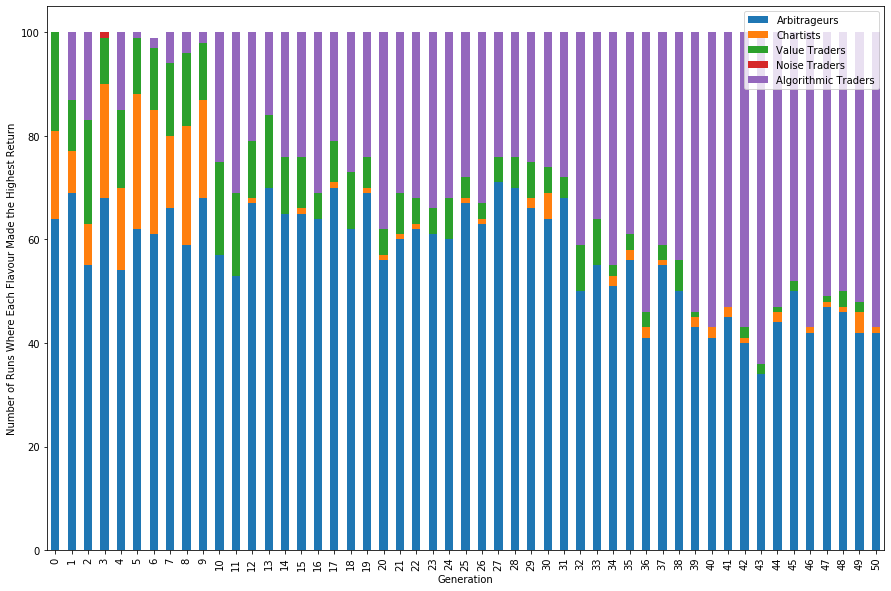

In [395]:
earning_ax = earning_data.plot(kind="bar", stacked=True, figsize=(15, 10))
plt.xlabel("Generation")
plt.ylabel("Number of Runs Where Each Flavour Made the Highest Return")
plt.savefig("top_earners_flavour_fig")

In [396]:
def compute_liquidity_check(fsdatadict, lower=10, upper=90):
    consuming_list = []
    supplying_list = []
    for k, v in fsdatadict.items():
        consuming_count = 0
        supplying_count = 0
        v1 = v[v.flavour == "lstm"]
        for i in range(len(v1)):
            if v1.iloc[i]["stock"] > upper or v1.iloc[i]["stock"] < lower:
                consuming_count += 1
            else:
                supplying_count += 1
        consuming_list.append(consuming_count)
        supplying_list.append(supplying_count)
    consuming_array = np.array(consuming_list)
    supplying_array = np.array(supplying_list)
    consuming_avg = np.mean(consuming_array)
    supplying_avg = np.mean(supplying_array)
    return consuming_avg, supplying_avg

def liquidity_check(fsdict, lower=10, upper=90):
    consuming_list = []
    supplying_list = []
    for k, v in fsdict.items():
        con, sup = compute_liquidity_check(v, lower, upper)
        consuming_list.append(con)
        supplying_list.append(sup)
    consuming_array = np.array(consuming_list)
    supplying_array = np.array(supplying_list)
    return consuming_array, supplying_array

In [397]:
con, sup = liquidity_check(fsdict, 1, 99)

In [398]:
liquidity_data = pd.DataFrame(data={"Liquidity-Consuming": con, "Liquidity-Supplying": sup}, index=gens)

In [399]:
liquidity_data

,Liquidity-Consuming,Liquidity-Supplying
0,0.000000,0.000000
1,0.570000,0.430000
2,1.210000,0.790000
3,2.090000,0.910000
4,2.910000,1.090000
5,3.860000,1.140000
6,5.020202,0.979798
7,5.570000,1.430000
8,6.270000,1.730000
9,7.870000,1.130000


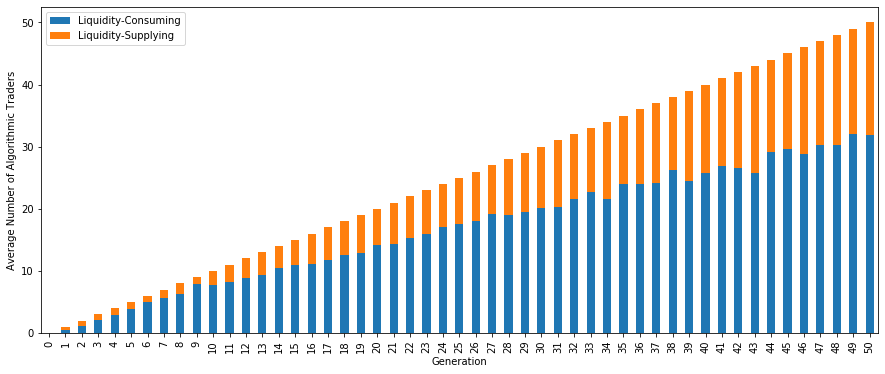

In [400]:
liquidity_ax = liquidity_data.plot(kind="bar", stacked=True, figsize=(15, 6))
plt.xlabel("Generation")
plt.ylabel("Average Number of Algorithmic Traders")
plt.savefig("liquidity_con_sup")

In [266]:
def compute_earnings(fsdatadict, gendatadict, gen):
    toplist = []
    for k, v in fsdatadict.items():
        sortedv = v.sort_values(by=["acc"], ascending=False)
        topacc = sortedv.iloc[0]["acc"]
        keyname = k
        if gen < 10:
            if len(keyname) == 14:
                number = keyname[-1]
            elif len(keyname) == 15:
                number = keyname[-2:]
            elif len(keyname) == 16:
                number = keyname[-3:]
            datakeyname = f"gen{gen}sim{number}"
        elif gen >= 10:
            if len(keyname) == 15:
                number = keyname[-1]
            elif len(keyname) == 16:
                number = keyname[-2:]
            elif len(keyname) == 17:
                number = keyname[-3:]
            datakeyname = f"/gen{gen}sim{number}"
        excess = topacc - (gendatadict[datakeyname].iloc[-1]["trading_price"]*100)
        toplist.append(excess)
    toparray = np.array(toplist)
    topacc_final = np.mean(toparray)
    return topacc_final

def earnings(fsdict, gendict):
    top_list = []
    for k, v in fsdict.items():
        top_acc = compute_earnings(v, gendict[k], k)
        top_list.append(top_acc)
    top_array = np.array(top_list)
    return top_array

In [267]:
top_earn = earnings(fsdict, gendict)

In [352]:
top_earn_return = top_earn/100

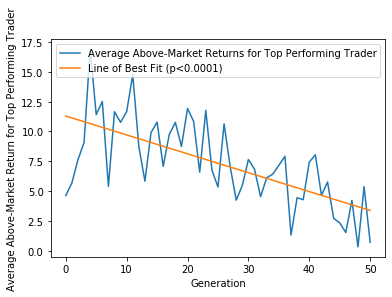

In [402]:
plt.plot(gendata.index, top_earn_return, label="Average Above-Market Returns for Top Performing Trader")
m, b = np.polyfit(gendata.index, top_earn_return, 1)
plt.plot(gendata.index, m*gendata.index + b, label="Line of Best Fit (p<0.0001)")
plt.legend()
plt.xlabel("Generation")
plt.ylabel("Average Above-Market Return for Top Performing Trader")
plt.savefig("excess_return_top_fig")

In [401]:
reg(top_earn_return)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.432
Model:                            OLS   Adj. R-squared:                  0.420
Method:                 Least Squares   F-statistic:                     37.23
Date:                Thu, 22 Apr 2021   Prob (F-statistic):           1.63e-07
Time:                        23:26:22   Log-Likelihood:                -122.51
No. Observations:                  51   AIC:                             249.0
Df Residuals:                      49   BIC:                             252.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.2920      0.753     15.003      0.000       9.779      12.804
x1            -0.1583      0.026     -6.102      0.000      -0.210      -0.106
==============================================================================
Omnibus:                        0.294   Durbin-Watson:                   1.626
Prob(Omnibus):                  0.863   Jarque-Bera (JB):                0.238
Skew:                          -0.156   Prob(JB):                        0.888
Kurtosis:                       2.876   Cond. No.                         57.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [270]:
def compute_average_earnings(fsdatadict, gendatadict, gen):
    earninglist = []
    for k, v in fsdatadict.items():
        binaryacc = []
        acc = v["acc"].to_numpy(copy=True)
        keyname = k
        if gen < 10:
            if len(keyname) == 14:
                number = keyname[-1]
            elif len(keyname) == 15:
                number = keyname[-2:]
            elif len(keyname) == 16:
                number = keyname[-3:]
            datakeyname = f"gen{gen}sim{number}"
        elif gen >= 10:
            if len(keyname) == 15:
                number = keyname[-1]
            elif len(keyname) == 16:
                number = keyname[-2:]
            elif len(keyname) == 17:
                number = keyname[-3:]
            datakeyname = f"/gen{gen}sim{number}"
        excess = acc - (gendatadict[datakeyname].iloc[-1]["trading_price"]*100)
        for i in excess:
            binaryacc.append(1 if i > 0 else 0)
        earninglist.append(np.mean(np.array(binaryacc)))
    avg_excess = np.mean(np.array(earninglist))
    return avg_excess

def avg_earnings(fsdict, gendict):
    avg_earning_list = []
    for k, v in fsdict.items():
        avg_earning = compute_average_earnings(v, gendict[k], k)
        avg_earning_list.append(avg_earning)
    avg_earning_array = np.array(avg_earning_list)
    return avg_earning_array

In [271]:
avg_excess = avg_earnings(fsdict, gendict)

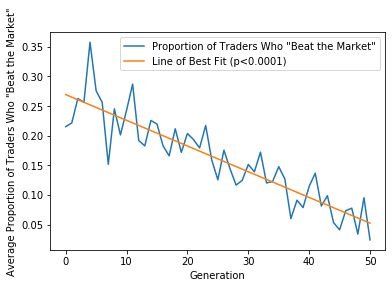

In [404]:
plt.plot(gendata.index, avg_excess, label="Proportion of Traders Who \"Beat the Market\"")
m, b = np.polyfit(gendata.index, avg_excess, 1)
plt.plot(gendata.index, m*gendata.index + b, label="Line of Best Fit (p<0.0001)")
plt.legend()
plt.xlabel("Generation")
plt.ylabel("Average Proportion of Traders Who \"Beat the Market\"")
plt.savefig("prop_who_beat_market")

In [403]:
reg(avg_excess)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.795
Model:                            OLS   Adj. R-squared:                  0.791
Method:                 Least Squares   F-statistic:                     190.1
Date:                Thu, 22 Apr 2021   Prob (F-statistic):           1.73e-18
Time:                        23:37:22   Log-Likelihood:                 102.52
No. Observations:                  51   AIC:                            -201.0
Df Residuals:                      49   BIC:                            -197.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2694      0.009     29.519      0.000       0.251       0.288
x1            -0.0043      0.000    -13.787      0.000      -0.005      -0.004
==============================================================================
Omnibus:                        4.924   Durbin-Watson:                   1.901
Prob(Omnibus):                  0.085   Jarque-Bera (JB):                4.753
Skew:                           0.337   Prob(JB):                       0.0929
Kurtosis:                       4.335   Cond. No.                         57.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [275]:
excessdata = pd.DataFrame(data={"Average Top Earnings": top_earn, 
                                "Proportion of Traders Who Beat the Market": avg_excess,
                                "Generation": gens}, index=gens)

In [276]:
excessdata

,Average Top Earnings,Proportion of Traders Who Beat the Market,Generation
0,462.75760,0.215300,0
1,568.46345,0.221485,1
2,763.29655,0.262745,2
3,906.62030,0.256408,3
4,1689.52550,0.357692,4
5,1141.49630,0.276000,5
6,1250.92596,0.256146,6
7,539.19030,0.151776,7
8,1165.07905,0.245278,8
9,1076.28080,0.201376,9


In [ ]:
# modeldict = {}
for i in range(1, 51):
    modeldict[i] = keras.models.load_model(f"/Users/karangarg/Documents/Year 3 Modules/EC331/Code/rae_repo/lstms/lstm{i}")

In [189]:
def format_data(datadict, window): #Turn dictionaries of data into features and samples lists
    x_data = []
    y_data = []
    for k, v in datadict.items():
        for i in range(len(v)):
            if i >= window:
                y_data.append(v.iloc[i]["trading_price"])
                xi = v.iloc[i-window:i].to_numpy()
                x_data.append(xi)
    x_data = np.array(x_data)
    y_data = np.array(y_data)
    y_data = np.reshape(y_data, (y_data.shape[0], 1))
    return x_data, y_data

def normalise_data(xarray, yarray): #Take the natural log and then normalise prices
    yarray_log = np.log(yarray)
    xarray_log = np.log(xarray)
    xsc = StandardScaler()
    instances, timesteps, features = xarray_log.shape
    xarray_log = np.reshape(xarray_log, (-1, features))
    xarray_norm = xsc.fit_transform(xarray_log)
    xarray_norm = np.reshape(xarray_norm, (instances, timesteps, features))
    ysc = StandardScaler().fit(yarray_log)
    yarray_norm = ysc.transform(yarray_log)
    return xarray_norm, yarray_norm, xsc, ysc

def var_importance(model, gen):
    gendata = gendict[gen]
    X, y = format_data(gendata, 20)
#    print(X)
    Xnorm, ynorm, Xsc, ysc = normalise_data(X, y)
    x = Xnorm # Get a sample of data
    orig_out = model.predict(x)
    effect_list = []
    for i in range(2):  # iterate over the three features
        new_x = x.copy()
        perturbation = np.random.normal(0.0, 0.2, size=new_x.shape[:2])
        new_x[:, :, i] = new_x[:, :, i] + perturbation
        perturbed_out = model.predict(new_x)
        effect = ((orig_out - perturbed_out) ** 2).mean() ** 0.5
        print(f'Variable {i+1}, perturbation effect: {effect:.4f}')
        effect_list.append(effect)
    effect_array = np.array(effect_list)
    return effect_array

def feature_check(modeldict):
    effect1_list = []
    effect2_list = []
    for k, v in modeldict.items():
        effect_array = var_importance(v, k-1)
        effect1_list.append(effect_array[0])
        effect2_list.append(effect_array[1])
    effect1_array = np.array(effect1_list)
    effect2_array = np.array(effect2_list)
    return effect1_array, effect2_array

In [188]:
var_importance(modeldict[1], 0)

Variable 1, perturbation effect: 0.0871
Variable 2, perturbation effect: 0.0201


In [190]:
trading_importance, true_importance = feature_check(modeldict)

Variable 1, perturbation effect: 0.0869
Variable 2, perturbation effect: 0.0201
Variable 1, perturbation effect: 0.0966
Variable 2, perturbation effect: 0.0132
Variable 1, perturbation effect: 0.1009
Variable 2, perturbation effect: 0.0155
Variable 1, perturbation effect: 0.0773
Variable 2, perturbation effect: 0.0163
Variable 1, perturbation effect: 0.0849
Variable 2, perturbation effect: 0.0113
Variable 1, perturbation effect: 0.0812
Variable 2, perturbation effect: 0.0082
Variable 1, perturbation effect: 0.0817
Variable 2, perturbation effect: 0.0089
Variable 1, perturbation effect: 0.0917
Variable 2, perturbation effect: 0.0143
Variable 1, perturbation effect: 0.0835
Variable 2, perturbation effect: 0.0078
Variable 1, perturbation effect: 0.0876
Variable 2, perturbation effect: 0.0115
Variable 1, perturbation effect: 0.0741
Variable 2, perturbation effect: 0.0068
Variable 1, perturbation effect: 0.0789
Variable 2, perturbation effect: 0.0108
Variable 1, perturbation effect: 0.0779


In [191]:
feature_scale = trading_importance/true_importance

In [192]:
feature_scale

array([ 4.32367067,  7.3015799 ,  6.49627952,  4.74843604,  7.54369471,
        9.89574818,  9.14392443,  6.42611089, 10.7333494 ,  7.6173556 ,
       10.90715196,  7.34365028,  9.83245965,  6.35495994,  7.22688796,
        4.87463841,  6.76123204,  8.19984726, 11.67089167,  6.97106345,
       12.0411308 ,  7.75177156,  6.84774308,  9.07021339,  6.72691975,
        8.67359445,  7.60906002,  6.56631751,  7.828022  ,  7.12679449,
       12.17209606,  7.31464695,  7.63566744,  7.67226566,  5.36572852,
        7.13248767,  8.92582013,  5.63622093,  8.07832389,  6.56773436,
        7.79026822,  6.05471642,  4.63556918, 12.29347929,  3.35888045,
        8.81443295,  3.66974007,  8.63429375,  2.95449189,  3.75643675])

In [408]:
featgens = np.array([i for i in range(1, 51)])

featdata = pd.DataFrame(data={"Trading Price Pertubation Effect": trading_importance,
                              "True Price Pertubation Effect": true_importance,
                              "Feature_Importance_Ratio": feature_scale,
                              "Generation": featgens
                             }
                              , index=featgens)

In [409]:
featdata

,Trading Price Pertubation Effect,True Price Pertubation Effect,Feature_Importance_Ratio,Generation
1,0.086946,0.020109,4.323671,1
2,0.096579,0.013227,7.301580,2
3,0.100869,0.015527,6.496280,3
4,0.077306,0.016280,4.748436,4
5,0.084946,0.011260,7.543695,5
6,0.081198,0.008205,9.895748,6
7,0.081709,0.008936,9.143924,7
8,0.091687,0.014268,6.426111,8
9,0.083475,0.007777,10.733349,9
10,0.087647,0.011506,7.617356,10


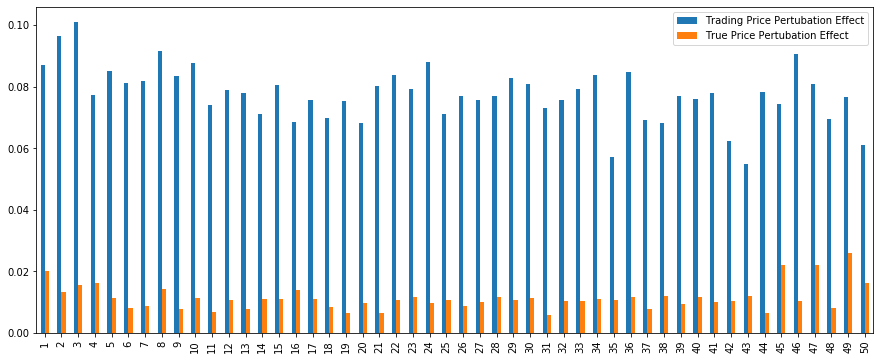

In [351]:
featax = featdata.plot(kind="bar", figsize=(15, 6))

-0.004194733237274071
0.18201507228871366
6.4213501328837115


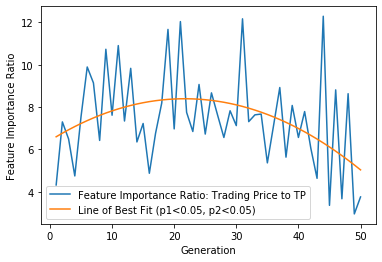

In [412]:
plt.plot(featdata.index, featdata["Feature_Importance_Ratio"], label="Feature Importance Ratio: Trading Price to TP")
m1,m2, b = np.polyfit(featdata.index, featdata["Feature_Importance_Ratio"], 2)
plt.plot(featdata.index, m1*(featdata.index)**2 + m2*(featdata.index) + b, label="Line of Best Fit (p1<0.05, p2<0.05)")
plt.legend()
plt.xlabel("Generation")
plt.ylabel("Feature Importance Ratio")
plt.savefig("feature_ratio_fig")
print(m1)
print(m2)
print(b)

In [225]:
model = smf.ols(formula = f'Feature_Importance_Ratio ~ Generation + I(Generation**2)', data = featdata).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                               
====================================================================================
Dep. Variable:     Feature_Importance_Ratio   R-squared:                       0.167
Model:                                  OLS   Adj. R-squared:                  0.132
Method:                       Least Squares   F-statistic:                     4.722
Date:                      Tue, 20 Apr 2021   Prob (F-statistic):             0.0135
Time:                              15:11:12   Log-Likelihood:                -106.16
No. Observations:                        50   AIC:                             218.3
Df Residuals:                            47   BIC:                             224.1
Df Model:                                 2                                         
Covariance Type:                  nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              6.4214      0.922      6.967      0.000       4.567       8.275
Generation             0.1820      0.083      2.183      0.034       0.014       0.350
I(Generation ** 2)    -0.0042      0.002     -2.647      0.011      -0.007      -0.001
==============================================================================
Omnibus:                        6.619   Durbin-Watson:                   2.689
Prob(Omnibus):                  0.037   Jarque-Bera (JB):                6.069
Skew:                           0.849   Prob(JB):                       0.0481
Kurtosis:                       3.172   Cond. No.                     3.59e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.59e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [226]:
reg(featdata["Feature_Importance_Ratio"], featdata.index)

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                               
====================================================================================
Dep. Variable:     Feature_Importance_Ratio   R-squared:                       0.043
Model:                                  OLS   Adj. R-squared:                  0.023
Method:                       Least Squares   F-statistic:                     2.166
Date:                      Tue, 20 Apr 2021   Prob (F-statistic):              0.148
Time:                              15:12:06   Log-Likelihood:                -109.64
No. Observations:                        50   AIC:                             223.3
Df Residuals:                            48   BIC:                             227.1
Df Model:                                 1                                         
Covariance Type:                  nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.2754      0.635     13.025      0.000       6.998       9.553
x1            -0.0319      0.022     -1.472      0.148      -0.076       0.012
==============================================================================
Omnibus:                        1.802   Durbin-Watson:                   2.349
Prob(Omnibus):                  0.406   Jarque-Bera (JB):                1.384
Skew:                           0.408   Prob(JB):                        0.500
Kurtosis:                       2.994   Cond. No.                         59.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [342]:
def compute_model_correlation(model_1, model_2):
    diff_list = []
    for ind, item in enumerate(model_1.layers[0].get_weights()):
        diff = item - model_2.layers[0].get_weights()[ind]
        diff_list.append(np.mean(diff))
    for ind, item in enumerate(model_1.layers[2].get_weights()):
        diff = item - model_2.layers[2].get_weights()[ind]
        diff_list.append(np.mean(diff))
    final_diff = (np.mean(np.array(diff_list)))**2
    return final_diff

def model_correlation(modeldict):
    corr_list = []
    for i in range(2, len(modeldict)):
        corr = compute_model_correlation(modeldict[i], modeldict[i-1])
        corr_list.append(corr)
    diff_array = np.array(corr_list)
    return diff_array

In [343]:
diff = model_correlation(modeldict)

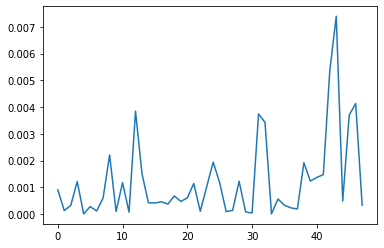

In [344]:
plt.plot(diff)

In [418]:
corrgens = np.array([i for i in range(48)])

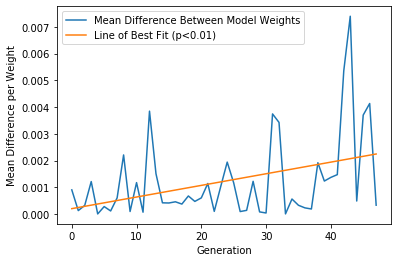

In [442]:
plt.plot(corrgens, diff, label="Mean Difference Between Model Weights")
m, b = np.polyfit(corrgens, diff, 1)
plt.plot(corrgens, m*corrgens + b, label="Line of Best Fit (p<0.01)")
plt.legend()
plt.xlabel("Generation")
plt.ylabel("Mean Difference per Weight")
plt.savefig("weight_diff_fig")

In [420]:
reg(diff, corrgens)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.151
Model:                            OLS   Adj. R-squared:                  0.133
Method:                 Least Squares   F-statistic:                     8.194
Date:                Fri, 23 Apr 2021   Prob (F-statistic):            0.00631
Time:                        17:33:30   Log-Likelihood:                 246.40
No. Observations:                  48   AIC:                            -488.8
Df Residuals:                      46   BIC:                            -485.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.000      0.494      0.623      -0.001       0.001
x1          4.347e-05   1.52e-05      2.862      0.006    1.29e-05     7.4e-05
==============================================================================
Omnibus:                       22.390   Durbin-Watson:                   1.663
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               33.655
Skew:                           1.521   Prob(JB):                     4.92e-08
Kurtosis:                       5.753   Cond. No.                         53.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [428]:
from skidmarks import wald_wolfowitz

In [448]:
def convert_to_runs(series):
    vallist = []
    for i in range(len(series)):
        if i == 0:
            continue
        if series[i-1] > series[i]:
            vallist.append(0)
        elif series[i-1] < series[i]:
            vallist.append(1)
    valarray = np.array(vallist)
    return valarray

def compute_runs(gendatadict, pcrit=0.05):
    runs_prop = []
    for k, v in gendatadict.items():
        price = v["trading_price"].to_numpy(copy=True)
        val = convert_to_runs(price)
        _, p = runtest(val)
        if p < pcrit:
            runs_prop.append(1)
        elif p > pcrit:
            runs_prop.append(0)
    run_prop = np.mean(np.array(runs_prop))
    return run_prop

def runs_prop(gendict, pcrit=0.05):
    runs_prop = []
    for k, v in gendict.items():
        prop = compute_runs(v, pcrit)
        runs_prop.append(prop)
    runsarray = np.array(runs_prop)
    return runsarray

In [449]:
runtest_prop = runs_prop(gendict)

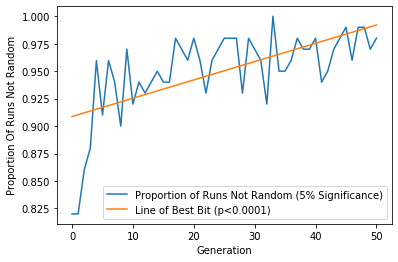

In [453]:
plt.plot(gens, runtest_prop, label="Proportion of Runs Not Random (5% Significance)")
m, b = np.polyfit(gens, runtest_prop, 1)
plt.plot(gens, m*gens + b, label="Line of Best Bit (p<0.0001)")
plt.legend()
plt.xlabel("Generation")
plt.ylabel("Proportion Of Runs Not Random")
plt.savefig("runs5_fig")

In [450]:
reg(runtest_prop)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.411
Model:                            OLS   Adj. R-squared:                  0.399
Method:                 Least Squares   F-statistic:                     34.18
Date:                Fri, 23 Apr 2021   Prob (F-statistic):           4.04e-07
Time:                        18:07:41   Log-Likelihood:                 107.52
No. Observations:                  51   AIC:                            -211.0
Df Residuals:                      49   BIC:                            -207.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9087      0.008    109.811      0.000       0.892       0.925
x1             0.0017      0.000      5.846      0.000       0.001       0.002
==============================================================================
Omnibus:                       11.553   Durbin-Watson:                   1.104
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               11.882
Skew:                          -0.960   Prob(JB):                      0.00263
Kurtosis:                       4.379   Cond. No.                         57.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [457]:
runtest_prop10 = runs_prop(gendict, 0.1)

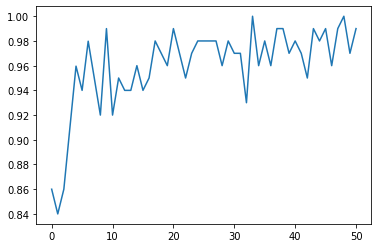

In [458]:
plt.plot(runtest_prop10)